# Per-Step DDPG Agent
#### 2023/05/19, AJ Zerouali

Goals of this notebook:
* Implement an abstract agent for custom portfolio optimization algorithms.
* Consolidate B. Cheng's Per-step DDPG code with this class.


#### **Note, comments, remarks:**

* 23/05/15 - 19:52: Now that I think about these reshaping questions for tensors, I am wondering if flattening the state matrices coming from the environment are a good idea. I don't like how these states are reshaped row by row, because it mixes too many things together. Here are 2 possibilities: 
    * Maybe it would make much more sense to reshape the transpose of the state matrix.
    * The other possibility is to have the input dimension of the policy exactly the same as the state shape. The question asked then is how you make the linear layers parameters and no. of neurons by layer.
    I wonder how I should design these neural nets...

* 23/05/15 - 20:03: Here is an easy way of testing the replay buffer:
    * Create a *replayBuffer* object. Take the buffer size to be 512 for simplicity.
    * Make a loop over the no. of periods in the environment.
    * Generate a random vector and normalize its entries so they're portfolio weights.
    * For each time you call *env.step(rand_wts)*, store in the buffer.


In [1]:
# GLOBAL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from datetime import datetime, timedelta, date
import gym
#import sys
import torch as th
from torch import nn
from torch import optim


## 0 - Reminders

Before implementing the actual agent, it will be important to recall:
1) How a pytorch neural net is trained, in particualr:
    * How the gradient coputations are turned on or off
    * The input of data as batches to a torch net
    * How one flattens a numpy array to a torch tensor
2) How a deep RL algorithm is written, that is:
    * The loop structure over all episodes and over one episode.
    * The rollout of transitions from the replay buffer.
    * The composition of batches of transitions.
    * The evalutation of the critic network over a batch of transitions.
    * The policy weight update (gradient step).
For a concrete example, we can look at the SB3 implementation of TD3:

https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/td3/td3.py


### 1) Torch nets and dataloaders

### 2) Training method of a deep RL algorithm

As a study case, let's look at SB3's *train()* method for TD3:

In [ ]:
def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        '''
            Set training mode on. This is for torch's evaluation of gradients
        '''
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        
        '''
            Update the learning rate. I won't use it but nice to know.
        '''
        # Update learning rate according to lr schedule
        self._update_learning_rate([self.actor.optimizer, self.critic.optimizer])

        actor_losses, critic_losses = [], []
        
        '''
            MAIN LOOP
            SB3 loop over the total no. of training steps.
        '''
        for _ in range(gradient_steps):
            self._n_updates += 1
            
            '''
                Sample a batch of transitions from the replay buffer.
            '''
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)  # type: ignore[union-attr]

            with th.no_grad():
                # Select action according to policy and add clipped noise
                noise = replay_data.actions.clone().data.normal_(0, self.target_policy_noise)
                noise = noise.clamp(-self.target_noise_clip, self.target_noise_clip)
                next_actions = (self.actor_target(replay_data.next_observations) + noise).clamp(-1, 1)

                # Compute the next Q-values: min over all critics targets
                next_q_values = th.cat(self.critic_target(replay_data.next_observations, next_actions), dim=1)
                next_q_values, _ = th.min(next_q_values, dim=1, keepdim=True)
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            '''
                POLICY EVALUATION STEP (CRITIC VALUE)
                This instruction evaluates a batch of actions over a batch of states.
                In simple terms: Here we're computing Q(s,a)
            '''
            # Get current Q-values estimates for each critic network
            current_q_values = self.critic(replay_data.observations, replay_data.actions)
            
            '''
                CRITIC LOSS COMPUTATION
            '''
            # Compute critic loss
            critic_loss = sum(F.mse_loss(current_q, target_q_values) for current_q in current_q_values)
            assert isinstance(critic_loss, th.Tensor)
            critic_losses.append(critic_loss.item())
            
            '''
                CRITIC GRADIENT STEP
            '''
            # Optimize the critics
            self.critic.optimizer.zero_grad()
            critic_loss.backward()
            self.critic.optimizer.step()

            # Delayed policy updates
            if self._n_updates % self.policy_delay == 0:
                '''
                    ACTOR LOSS COMPUTATION
                '''
                # Compute actor loss
                actor_loss = -self.critic.q1_forward(replay_data.observations, self.actor(replay_data.observations)).mean()
                actor_losses.append(actor_loss.item())
                
                '''
                    ACTOR GRADIENT STEP
                '''
                # Optimize the actor
                self.actor.optimizer.zero_grad()
                actor_loss.backward()
                self.actor.optimizer.step()

                polyak_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
                polyak_update(self.actor.parameters(), self.actor_target.parameters(), self.tau)
                # Copy running stats, see GH issue #996
                polyak_update(self.critic_batch_norm_stats, self.critic_batch_norm_stats_target, 1.0)
                polyak_update(self.actor_batch_norm_stats, self.actor_batch_norm_stats_target, 1.0)

        '''
            Book-keeping...
        '''
        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        if len(actor_losses) > 0:
            self.logger.record("train/actor_loss", np.mean(actor_losses))
        self.logger.record("train/critic_loss", np.mean(critic_losses))

## A - Per-step DDPG - External Implementation

We'll do things in a simple way first: Implement the model (actor+"critic"), its training, and the running of backtest outside the agent class. This is to ensure that the torch modules are compatible with our environment class and the way we do our computations here.

To this end, we'll go through the following subsections:

1) Data loading, processing and splitting

2) Model implementation

3) Agent main functions implementation


In [1]:
# GLOBAL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
import gym
# deque and random
from collections import deque
import random
#import sys
import torch as th
from torch import nn
from torch import optim
from drl_pfopt import (PortfolioOptEnv, FeatureEngineer, data_split, AlpacaDownloader, YahooDownloader)
from dual_timeframe_XP import (PFOptDualTFEnv, FeatureEngDualTF, data_dict_split)


/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### (1) Data loading, processing and splitting

The usual...

In [2]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])
TICKER_LIST = ['AXP', 'BA', 'CVX', 'JNJ', 'KO']


# Reduce to 10 stocks
df_file = df_Alpaca_15min[df_Alpaca_15min.tic.isin(TICKER_LIST)].copy()
del df_Alpaca_15min

In [3]:
# Feature Engineer params
trade_timeframe = "Hour"
trade_ext_hours = True
N_lookback_trade_prds = 15
tech_ind_list = ["turbulence"]
use_return_covs = True

# Instantiate feature eng. object
processor = FeatureEngDualTF(tech_indicator_list = tech_ind_list,
                             use_return_covs = use_return_covs,
                             data_source = "Alpaca")


# Preprocess data
data_dict = processor.preprocess_data(df_X = df_file,
                                      trade_timeframe = trade_timeframe,
                                      trade_ext_hours = trade_ext_hours,
                                      N_lookback_trade_prds = N_lookback_trade_prds,)

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str).
Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [4]:
# Data split
split_date = "2022-10-18"
data_dict_train, data_dict_test = data_dict_split(data_dict, split_date)

Now we create the environments corresponding to these datasets:

In [5]:
# Env parameters
#state_struct_list = ["volume", "close_returns", "returns_cov", "weights"]
state_struct_list = ["close_returns", "weights"]
weight_normalization = "identity"#"softmax"#"relu"
transaction_cost_pct = 0.0
reward_type = "portfolio_return"
pf_value_ini = 100000.0
plot_prds_end_episode=40

# Training environment
env_train = PFOptDualTFEnv(data_dict = data_dict_train,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

# Testing environment
env_test = PFOptDualTFEnv(data_dict = data_dict_test,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

print(f"obs_space_shape = {env_train.obs_space_shape}")

obs_space_shape = (65, 5)


### (2) Model implementation

In this part we will implement our actor, pseudo-critic and our replay buffer

#### 2.a - Actor implementation

The torch module we implement here predicts the optimal portfolio weights. I doubt that this is the correct approach...

In [6]:
'''
        ###############################
        ##### ACTOR NETWORK CLASS #####
        ###############################
        ## VERSION 0.0
        
'''
class Actor(nn.Module): 
    def __init__(self, state_dim, action_dim, h1, h2,  weight_normalization, init_w=0.003):
        
        super(Actor, self).__init__()        
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        
        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
                
        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1) ## dim = 1, across output dimension, not batch dimension shall be normalized
        
        # Weight computation/normalization function
        if weight_normalization == "softmax":
            self.compute_weights = self.softmax_normalization
        elif weight_normalization == "relu":
            self.compute_weights = self.relu_normalization
        
        # Device
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, state):
        
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        x = self.compute_weights(x)
        return x
    
    def softmax_normalization(self, action):
        '''
            :param action: th.Tensor
        '''
        weights = self.softmax(action)
        return weights
    
    def relu_normalization(self, action):
        action = (action+th.abs(action))/2
        weights = action/th.sum(action)
        '''
        if th.sum(action) != 0:
            weights = action/th.sum(action)
        else:
            weights = th.FloatTensor(np.ones(shape)).to(self.device)
        '''
        return weights

def fanin_(size):
    '''
        Helper function
    '''
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return th.Tensor(size).uniform_(-weight, weight)
    

In [7]:
'''
        ###############################
        ##### ACTOR NETWORK CLASS #####
        ###############################
        # A SECOND IMPLEMENTATION: 23/05/17
        COMMENTS (23/05/18)
         I made this second implementation for the following reasons
        - Initially, I had a major issue of NaN outputs.
        - I changed the activation of the last layer to sigmoid or tanh
          which resolved the NaN issues.
        - Initially, the environment computed the portfolio weights as
          some normalization of the agent actions, which clashed with
          Bill's implementation, and this furthermore required a normalization
          done by the pseudo-critic net. 
          The solution is to allow the environment to use the actions as 
          portfolio weights, and ensure that the agent actually produces
          normalized actions.
          
'''
class Actor(nn.Module): 
    def __init__(self, state_dim, action_dim, h1, h2,  weight_normalization, init_w=0.003):
        
        super(Actor, self).__init__()        
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        
        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
                
        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
                
        # Device
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, state):
        
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        # Actions in [0, 1]
        x = self.sigmoid(x)
        return x

def fanin_(size):
    '''
        Helper function
    '''
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return th.Tensor(size).uniform_(-weight, weight)
    

In [6]:
'''
        ###############################
        ##### ACTOR NETWORK CLASS #####
        ###############################
        # VERSION 3: 23/05/18
        COMMENTS (23/05/18)
        - The forward() method of this nn.Module computes
          portfolio weights.
        - At time of writing (23/05/18), there is only one
          action normalization implemented, softmax.
        - There are additional parameters, see docstring 
          of constructor.
        
'''
class Actor(nn.Module):
    '''
        Actor class for DDPG per-step algorithm
    '''
    def __init__(self, 
                 state_dim: int, 
                 action_dim: int, 
                 h1: int, 
                 h2: int,
                 weight_normalization: str = "softmax", 
                 activation_fn: str = "sigmoid", #sigmoid, tanh, relu
                 activation_scale: float = 1.0,
                 init_w: float = 0.003,
                ):
        '''
            :param state_dim: int, no. of units in input layer.
                        Should be the shape obtained from state.view(1,-1)
                        if "state" is an array returned by the environment.
            :param action_dim: int, no. of components of output vector.
                        Should equal env.n_assets if env is the environment
                        used.
            :param h1: int, no. of neurons in 1st hidden layer.
            :param h2: int, no. of neurons in 2nd hidden layer.
            :param weight_normalization: str, normalization type for portfolio weights.
                        default is "softmax"
            :param activation_fn: str, 
            :param activation_scale: float, multiplication factor for pre-normalization 
                        activation. Default: 1.0.
            :param init_w: float, weight initialization. Default: 0.003.
            
        '''
        
        super(Actor, self).__init__()
        
        # Layers
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        # Activation functions
        self.activation_scale = activation_scale
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim = 1)
        if activation_fn == "sigmoid":
            self.activation_fn = self.sigmoid
        elif activation_fn == "tanh":
            self.activation_fn = self.tanh
        elif activation_fn == "relu":
            self.activation_fn = self.relu
        elif activation_fn == "identity":
            self.activation_fn = self.identity_activation
        else:
            raise ValueError(f"Activation function {activation_fn} is not supported")
        
        # Normalization to portfolio weights
        if weight_normalization == "softmax":
            self.normalize = self.softmax_normalization
        elif weight_normalization == "relu":
            self.normalize = self.relu_normalization
        else:
            raise ValueError(f"Weight normalization{weight_normalization} is not supported")
        
                
        # Device
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        self.to(self.device)
    
    def identity_activation(self,
                            x: th.FloatTensor,
                           ):
        return x
    
    def softmax_normalization(self,
                              x: th.FloatTensor,
                             ):
        return self.softmax(x)
    
    def relu_normalization(self,):
        raise NotImplementedError("relu normalization not supported")
    
    def forward(self, state):
        
        # Forward pass thru layers
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        # Pre-normalization activation
        x = self.activation_fn(x)
        x = self.activation_scale*x
        # Normalization to portfolio weights
        x = self.normalize(x)
        return x

def fanin_(size):
    '''
        Helper function
    '''
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return th.Tensor(size).uniform_(-weight, weight)
    

#### **Testing the actor net**

Let's test this on the first state of the training env.

In [7]:
env_train.obs_space_shape

(74, 5)

In [8]:
# Actor parameters
dim_in = env_train.obs_space_shape[0]*env_train.obs_space_shape[1]
n_hidden_1 = 4*dim_in
n_hidden_2 = 2*dim_in
dim_out = env_train.n_assets
weight_normalization = env_train.weight_normalization

# Instantiate actor net
actor_net = Actor(state_dim=dim_in, 
                  action_dim = dim_out, 
                  h1 = n_hidden_1, 
                  h2 = n_hidden_2,
                  weight_normalization = weight_normalization,
                 )

Compute some input from first state:

In [9]:
# First state
S_0 = env_train.X[0,:,:]
S_0_ = th.FloatTensor(S_0).to(actor_net.device)


In [ ]:
S_0_.shape

torch.Size([74, 5])

In [ ]:
S_0_.view(1,-1).shape

torch.Size([1, 370])

In [ ]:
S_0_.device

device(type='cpu')

In [ ]:
dim_in

370

In [10]:
a = actor_net(S_0_.view(1,-1))

In [11]:
a

tensor([[0.4351, 0.5649, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [12]:
np_a = a.detach().cpu().numpy()

In [14]:
np_a[0]

array([0.43506992, 0.5649301 , 0.        , 0.        , 0.        ],
      dtype=float32)

#### **Additional notes for later**

**A short summary:** To evaluate the neural net on a given state at time *t*, we:
* Convert the state to a torch tensor, reshape it, and send it to the device of the net:

        # Numpy state array
        S_t = env_train.X[t,:,:]
        
        # Convert to torch tensor and send to net device
        S_t_ = th.FloatTensor(S_t).to(actor_net.device)
        
        # Reshape and evaluate:
        a_t_ = actor_net(S_t_.view(1,-1))
        
* **IMPORTANT:** It's important to distinguish between the *batch_first=True* and *False* cases. Note that:
        
        # batch_first = True
        S_t_.view(1,-1).shape = (1, dim_in)
        
        # batch_first = False
        S_t_.view(1,-1).shape = (dim_in, 1)
        
In the second case, the instruction:

        actor_net(S_t_.view(1,-1))
        
returns an error, because of the mismatch with the dimension of the first layer of *actor_net*. (I think this is the correct way to do it). Now

In [ ]:
S_0.reshape(1,-1).shape

(1, 370)

In [ ]:
print(f"S_0.reshape(-1).shape = {S_0.reshape(-1).shape}")
print(f"S_0.squeeze().shape = {S_0.squeeze().shape}")
print(f"S_0.flatten().shape = {S_0.flatten().shape}")

S_0.reshape(-1).shape = (370,)
S_0.squeeze().shape = (74, 5)
S_0.flatten().shape = (370,)


In [ ]:
S_0_sqz = S_0.reshape

It would be worth understanding what the following instructions do:

        s = env_train.reset()
        s = s.flatten()
        s = torch.from_numpy(s).float().unsqueeze(0)
        
I hate the machine learning lingo...

In [ ]:
# Copy init. state
s = S_0

# flatten
s = s.flatten()
print(f"s.shape = {s.shape}; type(s) = {type(s)}")

# float and unsqueeze
s = th.from_numpy(s).float().unsqueeze(0)
print(f"s.shape = {s.shape}; type(s) = {type(s)}")

s.shape = (370,); type(s) = <class 'numpy.ndarray'>
s.shape = torch.Size([1, 370]); type(s) = <class 'torch.Tensor'>


Note that *view(1,-1)* and *flatten()* do exactly what we'd expect: The rows are concatenated.

In [ ]:
S_0.shape

(74, 5)

In [ ]:
S_0[0,:]

array([100., 133., 261., 240., 532.])

In [ ]:
S_0.flatten()[:5]

array([100., 133., 261., 240., 532.])

In [ ]:
s[0,:5]

tensor([100., 133., 261., 240., 532.])

Later, we will also use the following function:

In [ ]:
if True:
    def get_action(actor, state):
        state_  = th.FloatTensor(state).to(actor.device)
        action = actor.forward(state_.view(1,-1))
        return action.cpu().detach().numpy()[0]

In [ ]:
get_action(actor_net, S_0)

array([0.52933687, 0.08763179, 0.        , 0.        , 0.38303134],
      dtype=float32)

**Comment:** I should test the replay buffer aside too...

#### 2.b - Replay buffer

It will be useful to write the replay buffer before dealing with the critic, as the latter will perform a dot product on batches.

A class wrapping a deque object from which transitions will be sampled during training.

In [7]:
'''
        ###############################
        ##### REPLAY BUFFER CLASS #####
        ###############################
'''
class replayBuffer(object):
    def __init__(self, buffer_size, name_buffer=''):
        self.name_buffer = name_buffer
        self.buffer_size = buffer_size  #choose buffer size
        self.num_exp = 0
        self.buffer = deque()

    def add(self, s, a, r, s2, t):
        experience=(s, a, r, s2, t)
        if self.num_exp < self.buffer_size:
            self.buffer.append(experience)
            self.num_exp +=1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.buffer_size

    def count(self):
        return self.num_exp

    def sample(self, batch_size):
        if self.num_exp < batch_size:
            batch = random.sample(self.buffer, self.num_exp)
        else:
            batch = random.sample(self.buffer, batch_size)

        s, a, r, s2, t = map(np.stack, zip(*batch))

        return s, a, r, s2, t

    def clear(self):
        self.buffer = deque()
        self.num_exp=0

#### **Testing the replay buffer**

We instantiate a replay buffer object and fill it by running through the training environment (as a test).

The second thing we should test is how the critic network works with batches from this buffer

##### (0) Create replay buffer

In [32]:
# Main param
buffer_size = 512

# Instantiate buffer obj
replay_buffer = replayBuffer(buffer_size, name_buffer='test_buffer')

##### (1) Training environment run

Here we will reshape the states before adding them to the buffer

Initial portfolio value: 100000.0
End portfolio value: 90195.9811566346
Yearly Sharpe ratio at last period: -0.5243880465462665
Plotting portfolio values and weights for last 40 periods:


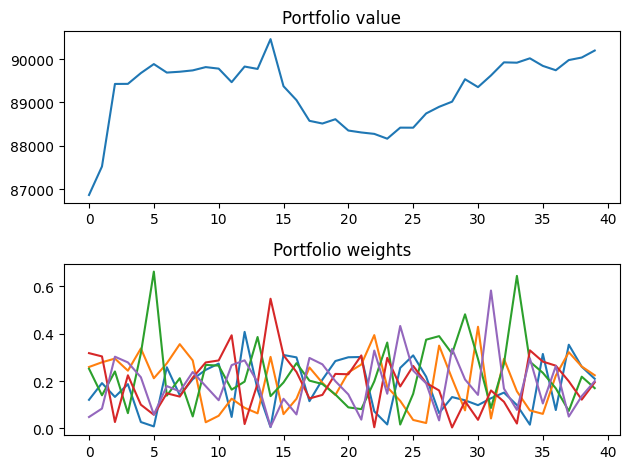

In [33]:
# Env parameters
N_periods = env_train.N_periods
n_assets = env_train.n_assets

# Reset env
s = env_train.reset()
done = False

# Main loop
while not done:
    
    # Choose a random action
    a = np.random.uniform(size = n_assets)
    if a.sum() == 0:
        a = np.ones(shape=n_assets)/n_assets
    else:
        a = a/a.sum()
    
    # Call env step()
    s_, r, done, _ = env_train.step(a)
    
    # Add transition to replay buffer
    replay_buffer.add(s.flatten(),a,r,s_.flatten(), env_train.t_idx)
    
    # Update current state
    s = s_

Now let's sample one batch:

In [36]:
# Params
batch_size = 32

# Sample batch
s_batch, a_batch, r_batch, s_next_batch, t_batch = replay_buffer.sample(batch_size)

Now this is what the output looks like:

In [ ]:
type(s_batch)

numpy.ndarray

In [37]:
s_batch.shape

(32, 325)

In [38]:
t_batch.shape

(32,)

In [ ]:
t_batch

array([523, 476, 571, 397, 808, 726, 436, 433, 799, 484, 535, 305, 599,
       341, 567, 329, 345, 763, 392, 558, 578, 308, 456, 715, 694, 675,
       597, 502, 369, 418, 760, 633])

In [ ]:
train_clrets[t_batch,:].shape

(32, 5)

In [ ]:
train_clrets[523,:]

array([-0.00466926, -0.00429624, -0.00568037, -0.00332286, -0.00141678])

In [ ]:
train_clrets[t_batch,:][0]

array([-0.00466926, -0.00429624, -0.00568037, -0.00332286, -0.00141678])

In [ ]:
a_batch.shape

(32, 5)

In [ ]:
a_batch.T.shape

(5, 32)

##### **Torch Batch Matrix multiplication**

We'll test *th.bmm()* aside here. From the replay buffer we have a batch of states and rewards, now we'll need a batch of actions evaluated on these states, as well as a batch of returns (corresp to the states).

We'll need two helper functions: One to evaluate actions and the other to compute the close returns for "prediction".

In [12]:
if True:
    def get_action(actor, state):
        state_  = th.FloatTensor(state).to(actor.device)
        action = actor.forward(state_.view(1,-1))
        return action.cpu().detach().numpy()[0]
    
    def get_returns_array(env: PortfolioOptEnv,):
        '''
            Function to compute the close returns array 
            from the dataset contained in an environment.
            Here we assume it's a dual timeframe env.
            These are not exactly the same close returns as 
            the ones computed in the env state features.
        '''
        # Get close timestamp list
        close_timestamp_list = []
        trade_timestamp_list = env.trade_timeframe_info_dict["trade_timestamp_list"]
        trading_data_schedule = env.trade_timeframe_info_dict["trading_data_schedule"]
        for trade_timestamp in trade_timestamp_list:
            close_timestamp_list.append(trading_data_schedule[trade_timestamp][-1])
        
        # Get reduced close prices dataframe and array, compute close returns
        df_close = env.df_X[env.df_X["date"].isin(close_timestamp_list)]
        df_close = df_close.pivot_table(index='date',columns = 'tic',values = 'close')
        np_close = df_close.to_numpy()
        X_close_ret = np.zeros(shape=(len(trade_timestamp_list),env.n_assets))
        X_close_ret[1:,:] = (np_close[1:,:]-np_close[:-1,:])/np_close[:-1,:]
        
        # Return output
        return X_close_ret


Start by making an actor net:

In [13]:
# Actor parameters
dim_in = env_train.obs_space_shape[0]*env_train.obs_space_shape[1]
n_hidden_1 = 4*dim_in
n_hidden_2 = 2*dim_in
dim_out = env_train.n_assets
weight_normalization = env_train.weight_normalization

# Instantiate actor net
actor_net = Actor(state_dim=dim_in, 
                  action_dim = dim_out, 
                  h1 = n_hidden_1, 
                  h2 = n_hidden_2,
                  weight_normalization = weight_normalization,
                 )

Next, draw a batch of transitions from the buffer:

In [14]:
# Params
batch_size = 32

# Sample batch
s_batch, a_batch, r_batch, s_next_batch, t_batch = replay_buffer.sample(batch_size)

In [15]:
print(f"s_batch.shape = {s_batch.shape}; type(s_batch)={type(s_batch)}")

s_batch.shape = (32, 74, 5); type(s_batch)=<class 'numpy.ndarray'>


After that we need some close returns:

In [16]:
clrets_train = get_returns_array(env_train)

Now we test th.bmm()

In [37]:
# Get a batch of close price returns (using batch of t indices)
returns_batch = clrets_train[t_batch,:]
print(f"returns_batch.shape = {returns_batch.shape}, type(returns_batch) = {type(returns_batch)}")


returns_batch.shape = (32, 5), type(returns_batch) = <class 'numpy.ndarray'>


In [41]:
# Get actions batch from actor net and state batch
s_batch_ = th.FloatTensor(s_batch.reshape(batch_size, dim_in)).to(actor_net.device) # Now I see why they were flattening the states BEFORE storing the buffer
a_batch = actor_net(s_batch_)
print(f"a_batch.shape = {a_batch.shape}, type(a_batch) = {type(a_batch)}")


a_batch.shape = torch.Size([32, 5]), type(a_batch) = <class 'torch.Tensor'>


In [45]:
# Convert returns to tensor
returns_batch_ = th.FloatTensor(returns_batch).to(actor_net.device)

# Batch inner product
prod_batch = th.bmm(a_batch.unsqueeze(1), returns_batch_.unsqueeze(2))
print(f"prod_batch.shape = {prod_batch.shape}; type(prod_batch) = {type(prod_batch)}")

prod_batch.shape = torch.Size([32, 1, 1]); type(prod_batch) = <class 'torch.Tensor'>


In [43]:
returns_batch_ = th.FloatTensor(returns_batch).to(actor_net.device)
print(f"returns_batch_.shape = {returns_batch_.shape}; type(returns_batch_) = {type(returns_batch_)}")
reshaped_returns_batch_ = returns_batch_.unsqueeze(1)
print(f"reshaped_returns_batch_.shape = {reshaped_returns_batch_.shape}; type(reshaped_returns_batch_) = {type(reshaped_returns_batch_)}")

returns_batch_.shape = torch.Size([32, 5]); type(returns_batch_) = <class 'torch.Tensor'>
reshaped_returns_batch_.shape = torch.Size([32, 1, 5]); type(reshaped_returns_batch_) = <class 'torch.Tensor'>


#### 2.c - Pseudo-critic implementation

This torch module computes an approximation of the portfolio return given the latest close prices available. Its forward function has to compute the dot product of the portfolio weights and the adequate close returns. The close returns are computed when setting-up the full model (see next section).

In [18]:
'''
        ################################
        ##### CRITIC NETWORK CLASS #####
        ################################
        VERSION 0.0 Not properly speaking a critic.
'''
class R_Critic(nn.Module):
    
    def __init__(self, n_assets):
        '''
          :param n_assets: int, no. of portfolio assets


        # Will not work with the new environment
        df_close = df_X.pivot_table(index='date',columns = 'tic',values = 'close')
        df_change = df_close.pct_change()
        self.X = df_change.dropna().values
        # self.times = t_list
        
        # Will have to get close returns from
        # the trading_data_schedule of the env
        # Instead of the dataframe, might need the entire
        # environment.
        # Main question after that: How to make batches
        
        #### IMPORTANT ###
        # Should I add a th.device attribute to the critic?
        # How do I make it communicate with the agent global device?
        
        #### HOW DO NORMALIZE THE ACTIONS HERE?
        '''
        super(R_Critic, self).__init__()
        # Device
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        self.to(self.device)
        # Input shape param
        self.n_assets = n_assets
    
    def forward(self,
                action_t: th.FloatTensor, 
                returns_t: th.FloatTensor,
                batch_size: int): 
        '''
          Pseudo-critic forward function. Inputs are batches of 
          actions and close returns, which must both have shape
          (batch_size, n_assets)

          :param action_t: th.FloatTensor, batch of actions.
          :param returns_t: th.FloatTensor, batch of close price returns.
          :param batch_size: int, no. of elements in batch.

        #### IMPORTANT ####
        How do you compute the inner product over a batch?
        MAKE SURE YOU GET THE RIGHT DIMENSIONS BELOW!!!
        Check the docs: https://pytorch.org/docs/stable/generated/torch.bmm.html
        From a pythonic perspective, I think the input should be torch tensors
        instead of np arrays.
        The issue though is the complication added by reshaping the input tensors
        before calling R_Critic.forward(), since the user isn't necessarily aware
        of the expected shapes. Ideally, the input should be a batch of actions
        and a batch of returns, and if we're actually using th.bmm(), the reshaping 
        should be done within the forward() function.
        '''
        # Required input shape
        input_shape = (batch_size, self.n_assets)
    
        # Ensure that the shape is correct
        if (action_t.shape != input_shape) or (returns_t.shape != input_shape):
            raise ValueError("action_t and returns_t must both have shapes equal to (batch_size, n_assets)")

        # COMMENT: For th.bmm(batch_1, batch_2), you will need:
        ## batch_1.shape = (batch_size, n, m), batch_1.shape = (batch_size, m, l),
        ## so that the (n,m)x(m,l) matrix multiplication is defined.
        prod_batch = th.bmm(action_t.unsqueeze(1),
                            returns_t.unsqueeze(2)
                            ).squeeze(1)

        return prod_batch


In [15]:

'''
        ################################
        ##### CRITIC NETWORK CLASS #####
        ################################
        # A SECOND IMPLEMENTATION: 23/05/17
        COMMENTS (23/05/18)
         Continuation of the comments made for the second implementation
         of the actor class in sec. 2.a.
        - This implementation of the critic assumes that the agent
          actions are not portfolio weights, hence the additional
          normalization in the forward() method.
'''
class R_Critic(nn.Module):
    
    def __init__(self, env: PortfolioOptEnv):
        '''
          :param env: PortfolioOptEnv, environment 
        
        # Will have to get close returns from
        # the trading_data_schedule of the env
        # Instead of the dataframe, might need the entire
        # environment.
        # Main question after that: How to make batches
        
        #### IMPORTANT ###
        # Should I add a th.device attribute to the critic?
        # How do I make it communicate with the agent global device?
        
        #### HOW DO NORMALIZE THE ACTIONS HERE?
        '''
        super(R_Critic, self).__init__()
        # Device
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        self.to(self.device)
        
        # nn functions
        self.ReLU = nn.ReLU()
        self.Softmax = nn.Softmax()
        
        # Input shape param
        self.n_assets = env.n_assets
        
        # Weight normalization
        self.weight_normalization = env.weight_normalization
        if self.weight_normalization == "softmax":
            self.compute_weights = self.softmax_weights
        '''
        if self.weight_normalization == "relu":
            self.compute_weights = self.relu_weights
        '''
        
        # Close returns hist
        self.CloseReturns = self.get_returns_array(env)
    
    def get_returns_array(self, env: PortfolioOptEnv,):
        '''
            Function to compute the close returns array 
            from the dataset contained in an environment.
            Here we assume it's a dual timeframe env.
            These are not exactly the same close returns as 
            the ones computed in the env state features.
        '''
        # Get close timestamp list
        close_timestamp_list = []
        trade_timestamp_list = env.trade_timeframe_info_dict["trade_timestamp_list"]
        trading_data_schedule = env.trade_timeframe_info_dict["trading_data_schedule"]
        for trade_timestamp in trade_timestamp_list:
            close_timestamp_list.append(trading_data_schedule[trade_timestamp][-1])
        
        # Get reduced close prices dataframe and array, compute close returns
        df_close = env.df_X[env.df_X["date"].isin(close_timestamp_list)]
        df_close = df_close.pivot_table(index='date',columns = 'tic',values = 'close')
        np_close = df_close.to_numpy()
        X_close_ret = np.zeros(shape=(len(trade_timestamp_list),env.n_assets))
        X_close_ret[1:,:] = (np_close[1:,:]-np_close[:-1,:])/np_close[:-1,:]
        
        # Return output
        return X_close_ret
    
    def softmax_weights(self, 
                        action_t: th.FloatTensor,
                       ):
        weights_t = self.Softmax(action_t)
        return weights_t
    
    def relu_weights(self, 
                     action_t: th.FloatTensor,
                    ):
        pass
        
        '''
        n_assets = self.n_assets
        batch_size = action_t.shape[0]
        relu_a_t = self.ReLU(action_t)
        
        if th.sum()
        '''

    def forward(self,
                action_t: th.FloatTensor, 
                t: np.ndarray,): 
        '''
          Pseudo-critic forward function. Inputs are batches of 
          actions and time indices. which must both have shape
          (batch_size, n_assets), where:
          - n_assets is one of the R_Critic attributes obtained
            from the env in the constructor.
          - batch_size is the length of the time index batch.
          The time index batch is used to 

          :param action_t: th.FloatTensor, batch of actions.
          :param returns_t: th.FloatTensor, batch of close price returns.
          :param batch_size: int, no. of elements in batch.

        #### IMPORTANT ####
        How do you compute the inner product over a batch?
        MAKE SURE YOU GET THE RIGHT DIMENSIONS BELOW!!!
        Check the docs: https://pytorch.org/docs/stable/generated/torch.bmm.html
        From a pythonic perspective, I think the input should be torch tensors
        instead of np arrays.
        The issue though is the complication added by reshaping the input tensors
        before calling R_Critic.forward(), since the user isn't necessarily aware
        of the expected shapes. Ideally, the input should be a batch of actions
        and a batch of returns, and if we're actually using th.bmm(), the reshaping 
        should be done within the forward() function.
        '''
        # Required input shape
        batch_size = len(t)
        input_shape = (batch_size, self.n_assets)
    
        # Ensure that the shape is correct
        if (action_t.shape != input_shape):
            raise ValueError("action_t must have shape (len(t), n_assets)")
            
        # Compute weights
        weights_t = self.compute_weights(action_t)

        # COMMENT: For th.bmm(batch_1, batch_2), you will need:
        ## batch_1.shape = (batch_size, n, m), batch_2.shape = (batch_size, m, l),
        ## so that the (n,m)x(m,l) matrix multiplication is defined.
        returns_t = th.FloatTensor(self.CloseReturns[t,:]).to(self.device)
        prod_batch = th.bmm(weights_t.unsqueeze(1),
                            returns_t.unsqueeze(2)
                            ).squeeze(1)

        return prod_batch


In [8]:

'''
        ################################
        ##### CRITIC NETWORK CLASS #####
        ################################
        # VERSION 3: 23/05/18
        COMMENTS (23/05/18)
'''
class R_Critic(nn.Module):
    '''
        Pseudo-critic module for DDPGPS agent.
        Uses the last available close price returns
        in the environment as a prediction of the
        portfolio asset returns.
        The forward function outputs the prediction
        of the portfolio return based on the
        actions interpreted as portfolio weights.
    '''
    
    def __init__(self, env: PortfolioOptEnv):
        '''
          :param env: PFOptDualTFEnv, environment object
        
        '''
        super(R_Critic, self).__init__()
        # Device
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        self.to(self.device)
        
        # Input shape param
        self.n_assets = env.n_assets
                
        # Close returns hist
        self.CloseReturns = self.get_returns_array(env)
    
    def get_returns_array(self, env: PortfolioOptEnv,):
        '''
            Function to compute the close returns array 
            from the dataset contained in an environment.
            Here, the env parameter is assumed to be a
            PFOptDualTFEnv object.
            These are not exactly the same close returns as 
            the ones computed in the env state features.
        '''
        # Get close timestamp list
        close_timestamp_list = []
        trade_timestamp_list = env.trade_timeframe_info_dict["trade_timestamp_list"]
        trading_data_schedule = env.trade_timeframe_info_dict["trading_data_schedule"]
        for trade_timestamp in trade_timestamp_list:
            close_timestamp_list.append(trading_data_schedule[trade_timestamp][-1])
        
        # Get reduced close prices dataframe and array, compute close returns
        df_close = env.df_X[env.df_X["date"].isin(close_timestamp_list)]
        df_close = df_close.pivot_table(index='date',columns = 'tic',values = 'close')
        np_close = df_close.to_numpy()
        X_close_ret = np.zeros(shape=(len(trade_timestamp_list),env.n_assets))
        X_close_ret[1:,:] = (np_close[1:,:]-np_close[:-1,:])/np_close[:-1,:]
        
        # Return output
        return X_close_ret

    def forward(self,
                action_t: th.FloatTensor, 
                t: np.ndarray,): 
        '''
          Pseudo-critic forward function. Inputs are batches of 
          actions and time indices. The action batch must have
          shape (batch_size, n_assets), where:
          - n_assets is one of the R_Critic attributes obtained
            from the env in the constructor.
          - batch_size is the length of the time index batch.
          The time index batch is used to locate the close price
          returns in the CloseReturns attribute computed from 
          environment (see constructor).
          The computation of the predicted portfolio return
          uses the torch.bmm() method:
          https://pytorch.org/docs/stable/generated/torch.bmm.html

          :param action_t: th.FloatTensor, batch of portfolio weights.
          :param t_idx: np.ndarray, batch of trading timestamp indices.
          
          :return prod_batch: th.FloatTensor, batch of predicted 
                              portfolio returns.
        '''
        # Required input shape
        batch_size = len(t)
        input_shape = (batch_size, self.n_assets)
    
        # Ensure that the shape is correct
        if (action_t.shape != input_shape):
            raise ValueError("action_t must have shape (len(t), n_assets)")

        # COMMENT: For th.bmm(batch_1, batch_2), you will need:
        ## batch_1.shape = (batch_size, n, m), batch_2.shape = (batch_size, m, l),
        ## so that the (n,m)x(m,l) matrix multiplication is defined.
        returns_t = th.FloatTensor(self.CloseReturns[t,:]).to(self.device)
        prod_batch = th.bmm(action_t.unsqueeze(1),
                            returns_t.unsqueeze(2)
                            ).squeeze(1)

        return prod_batch


#### **Testing the critic network**

Continuing the tests after the replay buffer. Make sure those cells are executed, in particular:
* The *replay_buffer* has been instantiated and filled with one environment execution.
* The *actor_network* has been instantiated with the environment params.
* The np array of close price returns (the predictor) *clrets_train* must have been computed.


##### First implementation test

In [19]:
# Instantiate the critic net
critic_net = R_Critic(n_assets = env_train.n_assets)

In [20]:
help(replay_buffer.sample)

Help on method sample in module __main__:

sample(batch_size) method of __main__.replayBuffer instance



In [21]:
# Draw a random batch
batch_size = 32
s_batch, action_batch, reward_batch, s_next_batch, t_batch = replay_buffer.sample(batch_size)

In [26]:
type(t_batch)

numpy.ndarray

In [27]:
type(t_batch[0])

numpy.int64

In [28]:
t_batch.shape

(32,)

In [30]:
len(t_batch)

32

In [29]:
t_batch.shape[0]

32

In [22]:
# Get action batch from state batch
s_batch_ = th.FloatTensor(s_batch.reshape(batch_size, dim_in)).to(actor_net.device)
a_batch_ = actor_net(s_batch_).to(critic_net.device)
print(f"a_batch_.shape = {a_batch_.shape}; type(a_batch_) = {type(a_batch_)}")
# Get returns batch from array and t_batch
returns_batch_ = th.FloatTensor(clrets_train[t_batch,:]).to(critic_net.device)
print(f"returns_batch_.shape = {returns_batch_.shape}; type(returns_batch_) = {type(returns_batch_)}")

a_batch_.shape = torch.Size([32, 5]); type(a_batch_) = <class 'torch.Tensor'>
returns_batch_.shape = torch.Size([32, 5]); type(returns_batch_) = <class 'torch.Tensor'>


In [23]:
# Use critic to evaluate
actor_loss_batch = critic_net(a_batch_, returns_batch_, batch_size)

In [24]:
actor_loss_batch.shape

torch.Size([32, 1])

In [25]:
actor_loss_batch

tensor([[ 1.9381e-05],
        [ 8.8154e-07],
        [ 2.5686e-08],
        [ 3.0653e-05],
        [-4.2770e-07],
        [-6.8963e-06],
        [-5.3464e-05],
        [ 2.0430e-07],
        [ 7.1110e-09],
        [-2.9681e-05],
        [ 2.1187e-07],
        [ 0.0000e+00],
        [ 1.8018e-03],
        [ 1.4901e-05],
        [ 3.8145e-07],
        [ 1.6310e-07],
        [-1.7311e-04],
        [ 1.5501e-05],
        [ 1.3604e-05],
        [-4.1426e-07],
        [ 1.6571e-05],
        [-6.2891e-06],
        [-9.3166e-06],
        [ 1.8217e-05],
        [-2.7207e-06],
        [ 2.3475e-08],
        [ 8.3853e-05],
        [-1.3737e-05],
        [-6.3648e-06],
        [-1.3336e-04],
        [-7.7093e-05],
        [-9.2014e-05]], device='cuda:0', grad_fn=<SqueezeBackward1>)

##### Second implementation test

In [32]:
# Instantiate the critic net
critic_net = R_Critic(env = env_train)

In [33]:
# Draw a random batch
batch_size = 32
s_batch, action_batch, reward_batch, s_next_batch, t_batch = replay_buffer.sample(batch_size)

In [34]:
# Get action batch from state batch
s_batch_ = th.FloatTensor(s_batch.reshape(batch_size, dim_in)).to(actor_net.device)
a_batch_ = actor_net(s_batch_).to(critic_net.device)
print(f"a_batch_.shape = {a_batch_.shape}; type(a_batch_) = {type(a_batch_)}")
# Get returns batch from array and t_batch
returns_batch_ = th.FloatTensor(clrets_train[t_batch,:]).to(critic_net.device)
print(f"returns_batch_.shape = {returns_batch_.shape}; type(returns_batch_) = {type(returns_batch_)}")

a_batch_.shape = torch.Size([32, 5]); type(a_batch_) = <class 'torch.Tensor'>
returns_batch_.shape = torch.Size([32, 5]); type(returns_batch_) = <class 'torch.Tensor'>


In [35]:
# Use critic to evaluate
actor_loss_batch = critic_net(a_batch_, t_batch)

In [36]:
actor_loss_batch.shape

torch.Size([32, 1])

In [37]:
actor_loss_batch

tensor([[ 7.3100e-06],
        [ 7.9484e-04],
        [ 1.6535e-07],
        [-2.1195e-08],
        [-2.0401e-06],
        [-7.0994e-08],
        [ 2.1451e-04],
        [-1.6372e-05],
        [ 6.1647e-06],
        [ 4.6195e-05],
        [-2.0789e-05],
        [-3.3896e-06],
        [ 1.4423e-06],
        [ 4.9396e-07],
        [ 1.0728e-06],
        [ 8.9732e-06],
        [ 9.8739e-05],
        [ 3.8365e-07],
        [-1.0696e-05],
        [ 1.1022e-07],
        [ 7.3384e-06],
        [-9.5974e-06],
        [ 7.2965e-06],
        [-1.3306e-05],
        [ 1.3522e-05],
        [ 2.8679e-05],
        [-3.4008e-05],
        [-2.6509e-06],
        [ 8.1941e-06],
        [-2.1406e-06],
        [-1.8275e-07],
        [ 7.5787e-09]], device='cuda:0', grad_fn=<SqueezeBackward1>)

##### Old test (ineffective)

Compute the training returns:

In [ ]:
if True:
    def get_returns_array(env: PortfolioOptEnv,):
        
        '''
            Function to compute the close returns array 
            from the dataset contained in an environment.
            Here we assume it's a dual timeframe env.
            These are not exactly the same close returns as 
            the ones computed in the env state features.
        '''
        # Get close timestamp list
        close_timestamp_list = []
        trade_timestamp_list = env.trade_timeframe_info_dict["trade_timestamp_list"]
        trading_data_schedule = env.trade_timeframe_info_dict["trading_data_schedule"]
        for trade_timestamp in trade_timestamp_list:
            close_timestamp_list.append(trading_data_schedule[trade_timestamp][-1])
        
        # Get reduced close prices dataframe and array, compute close returns
        df_close = env.df_X[env.df_X["date"].isin(close_timestamp_list)]
        df_close = df_close.pivot_table(index='date',columns = 'tic',values = 'close')
        np_close = df_close.to_numpy()
        X_close_ret = np.zeros(shape=(len(trade_timestamp_list),env.n_assets))
        X_close_ret[1:,:] = (np_close[1:,:]-np_close[:-1,:])/np_close[:-1,:]
        
        # Return output
        return X_close_ret

Equal weights action:

In [ ]:
a = np.ones(shape=(env_train.n_assets))/env_train.n_assets
print(f"a = {a}")

a = [0.2 0.2 0.2 0.2 0.2]


In [ ]:
train_clrets = get_returns_array(env_train)

In [ ]:
train_clrets.shape

(811, 5)

In [ ]:
train_clrets[:10]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.15686275e-03, -9.04950612e-03, -8.22173778e-03,
         1.61262455e-03, -2.16986981e-03],
       [ 0.00000000e+00, -1.19374478e-04, -1.44445142e-03,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.16332378e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.41309594e-03,  2.09080048e-03,  1.25710692e-02,
        -2.35754126e-03, -1.06399503e-03],
       [-1.10605075e-02, -1.49031297e-03, -5.02798779e-03,
         1.26224784e-04,  2.87662393e-04],
       [-2.63157895e-03, -1.24776119e-02, -2.39903664e-03,
         4.59941944e-03, -2.56489974e-03],
       [ 3.89182058e-03, -9.40088266e-03, -2.65949125e-03,
         3.49931161e-03, -1.01301333e-03],
       [ 4.33668441e-03,  1.38280797e-02,  7.08997365e-03,
        -6.00240096e-04,  7.80031201e-05],
       [ 1.01406608e-03,  3.72740801e-03, -2.80356364e-04,
        -1.49921350e-03

In [ ]:
train_clrets[0,:]

array([0., 0., 0., 0., 0.])

Stock returns at first trading period:

In [ ]:
train_clrets[1,:]

array([ 0.00215686, -0.00904951, -0.00822174,  0.00161262, -0.00216987])

Equal weights portfolio return at first trading period:

In [ ]:
r = np.dot(a, train_clrets[1,:])
print(f"r = np.dot(a, train_clrets[1,:]) = {r}")

r = np.dot(a, train_clrets[1,:]) = -0.003134325282876517


Now try with critic:

In [ ]:
critic_net = R_Critic()

In [ ]:
r_ = critic_net(a, train_clrets[1,:])
print(f"")

tensor([[[-0.0031]]], device='cuda:0')

Now we compute some product with the critic net:

In [ ]:
critic_net = R_Critic()

In [ ]:
ret_batch = critic_net(a_batch, train_clrets[t_batch,:])

In [ ]:
ret_batch

tensor([[[-1.3968e-04, -1.2852e-04, -1.6993e-04, -9.9404e-05, -4.2384e-05],
         [-1.4720e-03, -1.3544e-03, -1.7908e-03, -1.0476e-03, -4.4666e-04],
         [-8.1155e-04, -7.4671e-04, -9.8728e-04, -5.7753e-04, -2.4625e-04],
         [-1.4839e-03, -1.3654e-03, -1.8052e-03, -1.0560e-03, -4.5026e-04],
         [-7.6209e-04, -7.0121e-04, -9.2712e-04, -5.4234e-04, -2.3124e-04]],

        [[-1.4068e-03, -2.6878e-03, -1.3133e-03, -8.1687e-04, -8.0314e-05],
         [-1.3501e-03, -2.5794e-03, -1.2603e-03, -7.8392e-04, -7.7074e-05],
         [-2.6253e-04, -5.0157e-04, -2.4508e-04, -1.5244e-04, -1.4987e-05],
         [-1.7354e-04, -3.3156e-04, -1.6201e-04, -1.0077e-04, -9.9073e-06],
         [-8.5687e-04, -1.6371e-03, -7.9990e-04, -4.9754e-04, -4.8917e-05]],

        [[ 0.0000e+00,  1.5289e-03, -5.3273e-03, -8.1208e-04, -1.2845e-03],
         [ 0.0000e+00,  2.8646e-04, -9.9812e-04, -1.5215e-04, -2.4067e-04],
         [ 0.0000e+00,  9.8943e-05, -3.4475e-04, -5.2553e-05, -8.3128e-05],
        

### (3) Agent functions implementation

The hardest part of the task. We will need 3 functions here:

1) The *set_model()* function that instantitates the actor, "critic" and replay buffer. 
2) The *train_model()* function that implements our version of DDPG. 
2) The *run_backtest()* function that deploys the trained model. 

#### 3.a - Model setup implementation

This function sets up the model used by the agent for portfolio optimization. In brief:

**Input params:**
- The training environment, from which the data, weight normalization, and aprts of the net architectures are obtained.
- The *policy_kwargs*, containing the neural net architecture for the policy network.
- The *model_kwargs*, containing the learning hyperparameters (learn_rate, batch_size, buffer_size)

**Output:**
- Actor network.
- Pseudo critic module.

**Comment: Agent constructor**
I had the following list of attributes in my draft of the agent constructor:

        # Environment attributes
        self.reward_type = None
        self.train_close_returns = None
        self.test_close_returns = None
        
        # Actor attributes
        self.actor = None
        self.policy_optimizer = None
        # self.actor_kwargs       
        
        # Critic attributes
        self.critic = None
        
        # Replay buffer attributes
        self.replay_buffer = None
        self.buffer_size = None
        
        # Learning (hyper)parameters
        self.gamma = None
        self.learn_rate = None
        self.batch_size = None
        self.buffer_size = None

In [9]:
if True:    
    def set_model(train_env: PortfolioOptEnv,
                  actor_n_hidden_1: int = 400,
                  actor_n_hidden_2: int = 200,
                  weight_normalization: str = "softmax",
                  activation_fn: str = "sigmoid",
                  activation_scale: float = 1.0,
                  buffer_size: int = 1000,
                  learn_rate: float = 0.001,
                 ):
                
        # Build actor
        dim_in = train_env.obs_space_shape[0]*train_env.obs_space_shape[1]
        dim_out = train_env.n_assets
        actor = Actor(dim_in, 
                      dim_out, 
                      actor_n_hidden_1,
                      actor_n_hidden_2,
                      weight_normalization = weight_normalization,
                      activation_fn = activation_fn,
                      activation_scale = activation_scale,
                     )
        
        # Build pseudo-critic
        ## Note: The critic stores the training dataset close price returns
        critic = R_Critic(env = train_env)
        
        # Build replay buffer
        replay_buffer = replayBuffer(buffer_size)
        
        # Build policy optimizer
        policy_optimizer = th.optim.Adam(actor.parameters(), 
                                         lr=learn_rate)
                
        # Fill output dict
        model_dict = {}
        model_dict["actor"] = actor
        model_dict["policy_optimizer"] = policy_optimizer
        model_dict["critic"] = critic
        model_dict["ReplayBuffer"] = replay_buffer
        model_dict["reward_type"] = reward_type
        
        
        # Return model_dict
        return model_dict

#### 3.b - Model training implementation

This function sets up the model used by the agent for portfolio optimization. In brief:

**Input params:**
- The training environment, from which the data, weight normalization, and aprts of the net architectures are obtained.
- The model dictionary
**Output:**
- Validation Boolean


This is the hardest part of the task. A good guide on how this part is done is P. Tabor's implementation of TD3, in particular:




In [13]:
if True:
    def get_action(actor, state):
        state_  = th.FloatTensor(state).to(actor.device)
        action = actor.forward(state_.view(1,-1))
        #return action.cpu().detach().numpy()[0]
        return action.cpu().detach().numpy()
    
    def model_learn(actor: Actor,
                    critic: R_Critic,
                    replay_buffer: replayBuffer,
                    policy_optimizer: th.optim.Adam,
                    batch_size:int,
                   ):
        '''
            MAIN LEARNING ALGORITHM
        '''
        
        # Check no. of available transitions in buffer
        if replay_buffer.count() < batch_size:
            # Is this really a good idea
            # DEBUG
            #print(f"Skipped learning. replay_buffer.count() = {replay_buffer.count()}")
            return
        
        
        # Sample batch transitions
        ## NOTE: The states have been flattened here.
        s_batch, a_batch, r_batch, s_next_batch, t_batch = \
            replay_buffer.sample(batch_size)
        
        # Convert batch objs to th.FloatTensor objects
        ### Note: We only use the current states and time index batches below
        s_batch_ = th.FloatTensor(s_batch).to(actor.device)
        
        # Set gradients to 0 for policy optimizer
        policy_optimizer.zero_grad()
        
        # Compute actor loss
        policy_loss = -critic(actor(s_batch_), t_batch).mean()
        #policy_loss = -th.pow(100.0*critic(actor(s_batch_), t_batch).mean(),2)
        
        # Gradient step
        policy_loss.backward()
        policy_optimizer.step()
        
        # Return policy loss
        return policy_loss.cpu().detach().numpy()
        
    
    def train_model(train_env: PortfolioOptEnv, 
                    model_dict: dict,
                    n_train_rounds: int = 8,
                    batch_size: int = 32,
                    show_env_plots: bool = True,
                   ):
        
        # Unpack the model_dict
        ## NOTE: these become attributes in the agent class.
        actor = model_dict["actor"]
        policy_optimizer = model_dict["policy_optimizer"]
        critic = model_dict["critic"]
        replay_buffer = model_dict["ReplayBuffer"]
        reward_type = model_dict["reward_type"]
        
        # Disable env plots during training
        if not show_env_plots:
            train_env_plot_prds_end_episode = train_env.plot_prds_end_episode
            train_env.plot_prds_end_episode = 0
        
        # Init. average reward hist
        average_reward_hist = []
        average_policy_loss_hist = []
        
        # Training loop
        for episode in range(n_train_rounds):
            
            # Reset train_env
            s = train_env.reset()
            done = False
            
            # Reward averaging variables
            episode_reward_list = []
            episode_policy_loss_list = []
            episode_avg_reward = 0.0
            
            # DEBUG
            action_is_nan = False
            
            # Episode loop
            while not done and not action_is_nan:
                
                # Compute action from current state
                ## NOTE - CLASS VERSION: Only input is the state
                action = get_action(actor, s)
                action_is_nan = np.isnan(action).all()
                # DEBUG
                #print(f"action = {action}")
                if action_is_nan:
                    print(f"ACTION IS NAN")
                    print(f"TIME INDEX: train_env.t_idx = {train_env.t_idx}")
                    print(f"LAST STATE: s = {s}")
                    break

                # Step in train_env
                s_next, reward, done, info = train_env.step(action)
                
                ## Add current reward to hist
                episode_reward_list.append(reward)
                
                # Store transition in replay_buffer
                ## (Reshape the states in the buffer for convenience)
                replay_buffer.add(s.flatten(), action, reward, s_next.flatten(), train_env.t_idx)
                
                # Run DDPG per step
                ## The policy loss below in a numpy array
                policy_loss = model_learn(actor,
                                          critic,
                                          replay_buffer,
                                          policy_optimizer,
                                          batch_size)
                
                # Add current policy loss to list
                if replay_buffer.count() >= batch_size:
                    episode_policy_loss_list.append(policy_loss)
                
                # Update current state
                s = s_next
                
            # END EPISODE LOOP
            
            # DEBUG
            if action_is_nan:
                break
            
            # Store last episode's average reward
            ## Compute mean reward
            if train_env.reward_type == "portfolio_delta_val":
                episode_avg_reward = np.mean(episode_reward_list)
            elif train_env.reward_type == "portfolio_return":
                episode_log_returns = np.log(np.ones(shape = (len(episode_reward_list),))\
                                            +np.array(episode_reward_list)
                                            )
                episode_avg_reward = -1+np.exp(episode_log_returns.mean())
            ## Store
            average_reward_hist.append(episode_avg_reward)
            
            # Store last episode's average policy loss
            if replay_buffer.count() >= batch_size:
                episode_avg_policy_loss = np.mean(episode_policy_loss_list)
                average_policy_loss_hist.append(episode_avg_policy_loss)
            
            
            '''
            if episode % 1 == 0:

                print("################################# Start evaluation: ")
                eps_reward = evaluate_policy(actor,test_env_ret,reward_type = reward_type)
                average_reward_list.append(eps_reward)
                average_reward_list_train.append(episode_reward)
                print("################################# End evaluation: ")
                print()
            '''
        
            if (episode+1) % 4 == 0:
                print(f"######################################################")
                print(f"              TRAINING EPISODE: {episode+1}")
                print(f"######################################################")
                if train_env.reward_type == "portfolio_delta_val":
                    average = np.mean(average_reward_hist)
                    print(f"Average reward = {average} (portfolio delta val.)")
                elif train_env.reward_type == "portfolio_return":
                    log_returns = np.log(np.ones(shape = (len(average_reward_hist),))\
                                        +np.array(average_reward_hist)
                                        )
                    average = -1 + np.exp(log_returns.mean())
                    print(f"Average reward = {average} (portfolio return)")
                
                # before: policy loss isn't computed before buffer is filled
                if replay_buffer.count() >= batch_size:
                    avg_policy_loss = np.mean(average_policy_loss_hist)
                    print(f"Average policy loss = {avg_policy_loss}")
                
                print(f"######################################################")
            
    
        # END TRAINING LOOP
        
        # Plot policy loss and mean reward histories?
        
        # Done training
        
        # End of episode n_plots of environment
        if not show_env_plots:
            train_env.plot_prds_end_episode = train_env_plot_prds_end_episode
        
        # Fill output dict
        model_dict = {}
        model_dict["actor"] = actor
        model_dict["policy_optimizer"] = policy_optimizer
        model_dict["critic"] = critic
        model_dict["ReplayBuffer"] = replay_buffer
        model_dict["reward_type"] = reward_type
        
        return model_dict, average_reward_hist, average_policy_loss_hist


#### Training test

In [17]:
del model_dict

In [18]:
# Model parameters
actor_net_in_dim = env_train.obs_space_shape[0]*env_train.obs_space_shape[1]
n_hidden_1 = 250#actor_net_in_dim*4
n_hidden_2 = 50#actor_net_in_dim*2
actor_net_out_dim = env_train.n_assets
weight_normalization = 'softmax'
activation_fn = 'identity'
activation_scale = 1.0
buffer_size = 512
learn_rate = 0.001

# Create model
model_dict = set_model(train_env = env_train,
                       actor_n_hidden_1 = n_hidden_1,
                       actor_n_hidden_2 = n_hidden_1,
                       weight_normalization = weight_normalization,
                       activation_fn = activation_fn,
                       activation_scale = activation_scale,
                       buffer_size = buffer_size,
                       learn_rate = learn_rate)

In [49]:
s = env_train.reset()

In [50]:
env_train.N_periods

811

In [51]:
a = get_action(model_dict["actor"], s)
print(f"a = {a}")

a = [[0.20061699 0.19962493 0.20106383 0.19965638 0.19903784]]


In [19]:
# Learning params
n_train_rounds = 48
batch_size = 128

# Train the model
model_dict, average_reward_hist, average_policy_loss_hist\
    = train_model(train_env = env_train,
                  model_dict = model_dict,
                  n_train_rounds = n_train_rounds,
                  batch_size = batch_size,
                  show_env_plots=False
                 )

Initial portfolio value: 100000.0
End portfolio value: [98200.25367765]
Yearly Sharpe ratio at last period: -0.0361796297030336
Initial portfolio value: 100000.0
End portfolio value: [116368.78501594]
Yearly Sharpe ratio at last period: 0.6738163375078265
Initial portfolio value: 100000.0
End portfolio value: [119385.00221998]
Yearly Sharpe ratio at last period: 0.790821586224206
Initial portfolio value: 100000.0
End portfolio value: [104533.5884197]
Yearly Sharpe ratio at last period: 0.24210910876498162
######################################################
              TRAINING EPISODE: 4
######################################################
Average reward = 0.00010942473108932482 (portfolio return)
Average policy loss = -0.00034706457518041134
######################################################
Initial portfolio value: 100000.0
End portfolio value: [110898.27776886]
Yearly Sharpe ratio at last period: 0.5233156062234896
Initial portfolio value: 100000.0
End portfolio value: [1

## B - Per-step DDPG - Class Implementation

Same as above, but this time testing the DDPGPS_agent.py module.

In [1]:
# GLOBAL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
import gym
# deque and random
from collections import deque
import random
#import sys
import torch as th
from torch import nn
from torch import optim
from drl_pfopt import (PortfolioOptEnv, FeatureEngineer, data_split, AlpacaDownloader, YahooDownloader)
from dual_timeframe_XP import (PFOptDualTFEnv, FeatureEngDualTF, data_dict_split)
# Import class
from DDPGPS import DDPGPS_Agent

/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### (1) Data loading, processing and splitting

The usual...

In [2]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])
TICKER_LIST = ['AXP', 'BA', 'CVX', 'JNJ', 'KO']


# Reduce to 10 stocks
df_file = df_Alpaca_15min[df_Alpaca_15min.tic.isin(TICKER_LIST)].copy()
del df_Alpaca_15min

In [3]:
# Feature Engineer params
trade_timeframe = "Hour"
trade_ext_hours = True
N_lookback_trade_prds = 15
tech_ind_list = ["turbulence"]
use_return_covs = True

# Instantiate feature eng. object
processor = FeatureEngDualTF(tech_indicator_list = tech_ind_list,
                             use_return_covs = use_return_covs,
                             data_source = "Alpaca")


# Preprocess data
data_dict = processor.preprocess_data(df_X = df_file,
                                      trade_timeframe = trade_timeframe,
                                      trade_ext_hours = trade_ext_hours,
                                      N_lookback_trade_prds = N_lookback_trade_prds,)

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str).
Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [4]:
# Data split
split_date = "2022-10-18"
data_dict_train, data_dict_test = data_dict_split(data_dict, split_date)

Now we create the environments corresponding to these datasets:

In [5]:
# Env parameters
#state_struct_list = ["volume", "close_returns", "returns_cov", "weights"]
state_struct_list = ["close_returns", "weights"]
weight_normalization = "identity"#"softmax"#"relu"
transaction_cost_pct = 0.0
reward_type = "portfolio_return"
pf_value_ini = 100000.0
plot_prds_end_episode=40

# Training environment
env_train = PFOptDualTFEnv(data_dict = data_dict_train,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

# Testing environment
env_test = PFOptDualTFEnv(data_dict = data_dict_test,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

print(f"obs_space_shape = {env_train.obs_space_shape}")

obs_space_shape = (65, 5)


### (2) **DDPGPS_Agent Tests**


#### 2.a - Class Training test

In [10]:
del Agent

In [11]:
# Instantiate agent
Agent = DDPGPS_Agent(train_env = env_train,
                    model_fname = "DDPGPS_Test_0")

In [12]:
# Model parameters
actor_net_in_dim = env_train.obs_space_shape[0]*env_train.obs_space_shape[1]
n_hidden_1 = 250#actor_net_in_dim*4
n_hidden_2 = 50#actor_net_in_dim*2
actor_net_out_dim = env_train.n_assets
weight_normalization = 'softmax'
activation_fn = 'identity'
activation_scale = 1.0
buffer_size = 512
learn_rate = 0.001

# Create model
Agent.set_model(actor_n_hidden_1 = n_hidden_1,
                actor_n_hidden_2 = n_hidden_2,
                weight_normalization = weight_normalization,
                activation_fn = activation_fn,
                activation_scale = activation_scale,
                buffer_size = buffer_size,
                learn_rate = learn_rate,)

Per-step DDPG agent with given parameters has been successfully created.


True

Initial portfolio value: 100000.0
End portfolio value: [107090.47760411]
Yearly Sharpe ratio at last period: 0.3151942618927652
Initial portfolio value: 100000.0
End portfolio value: [114546.16374343]
Yearly Sharpe ratio at last period: 0.6140450443329347
Initial portfolio value: 100000.0
End portfolio value: [120582.14582082]
Yearly Sharpe ratio at last period: 0.864934656912324
Initial portfolio value: 100000.0
End portfolio value: [123335.50506183]
Yearly Sharpe ratio at last period: 0.9245766306723304
######################################################
              TRAINING EPISODE: 4
######################################################
Average reward = 0.00018534725821428566 (portfolio return)
Average policy loss = -0.0006617710459977388
######################################################
Initial portfolio value: 100000.0
End portfolio value: [102683.03482506]
Yearly Sharpe ratio at last period: 0.1416783596743188
Initial portfolio value: 100000.0
End portfolio value: [10

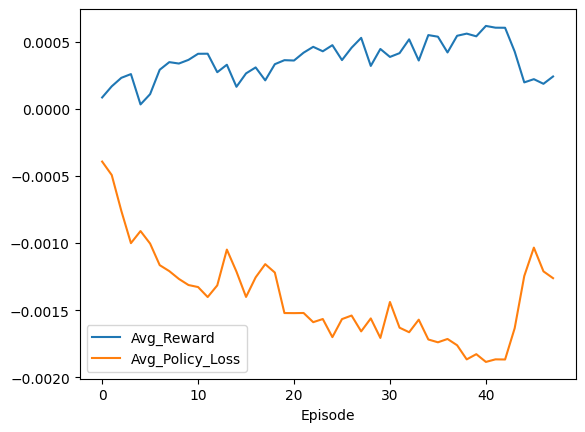

In [13]:
# Learning params
n_train_rounds = 48
batch_size = 128

# Train the model
average_reward_hist, average_policy_loss_hist\
    = Agent.train_model(n_train_rounds = n_train_rounds,
                        batch_size = batch_size,
                        show_env_plots=False
                       )

In [14]:
print(f"len(average_policy_loss_hist) = {len(average_policy_loss_hist)}")
print(f"len(average_reward_hist) = {len(average_reward_hist)}")

len(average_policy_loss_hist) = 48
len(average_reward_hist) = 48


In [15]:
df_train_hist = pd.DataFrame({"episode":range(len(average_reward_hist)),
                              "avg_rwd":average_reward_hist,
                              "avg_loss": average_policy_loss_hist
                             }).set_index("episode")

<AxesSubplot: xlabel='episode'>

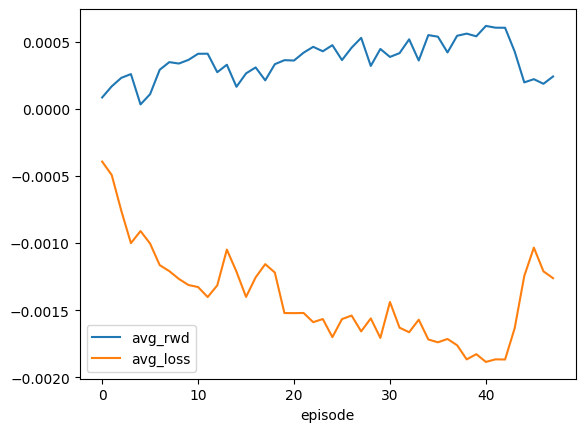

In [16]:
df_train_hist.plot()

Try a backtest for good measure.

Initial portfolio value: 100000.0
End portfolio value: [106294.86435435]
Yearly Sharpe ratio at last period: 0.9962303660950688
Plotting portfolio values and weights for last 40 periods:


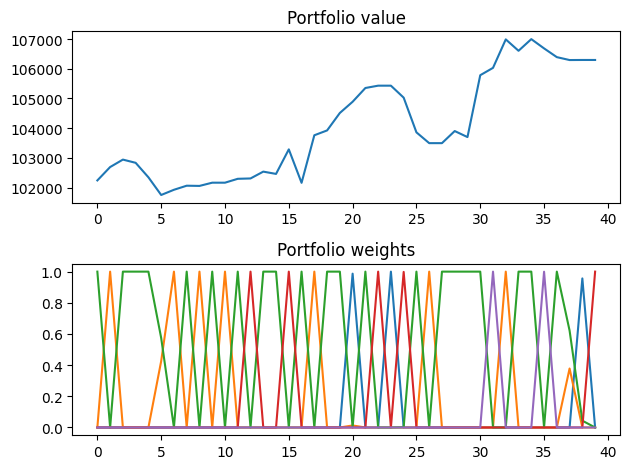

Finished running backtest. Storing results...


/usr/local/lib/python3.9/dist-packages/pyfolio/timeseries.py:730: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [17]:
# Backtest
backtest_result_dict = Agent.run_backtest(test_env = env_test)

In [18]:
backtest_result_dict.keys()

dict_keys(['value_hist', 'return_hist', 'weights_hist', 'agt_actions_hist', 'performance_stats'])

In [19]:
type(backtest_result_dict["value_hist"])

pandas.core.frame.DataFrame

<AxesSubplot: >

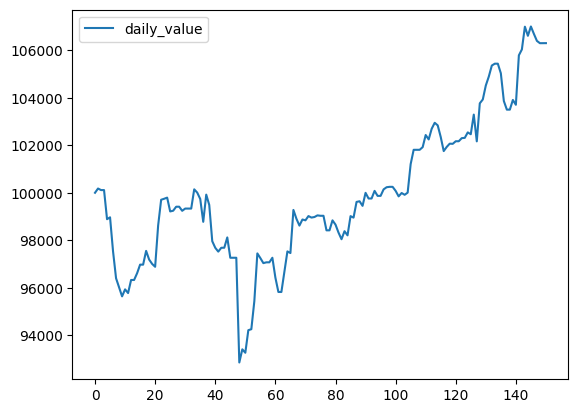

In [20]:
backtest_result_dict["value_hist"].plot()

<AxesSubplot: >

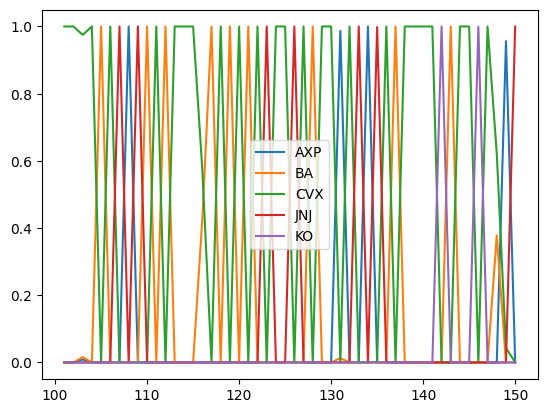

In [21]:
backtest_result_dict["agt_actions_hist"].iloc[-50:].plot()